# Testing FFT functions

In [199]:
# Import all necessary packages 

import numpy as np
import matplotlib.pyplot as plt   

from IPython.display import Audio,display 


In [200]:
# Class for the reuslts from windowed FFTs 

class FFTMagnitude:
    ''' class for storing instances of windowed FFT results, where window size and rolling window shift can be altered 
    
            PARAMETERS:
            magnitude: 2D array of FFT spectra, with shape (time_bins, frequency_bins) 
            frequency: central frequencies for each frequency band (Hz)
            n_window:  parameter deciding window size (window size = total number of samples/n_window)
            n_rolling: number of samples between rolling window '''

    def __init__(self,magnitude,frequency,n_window,n_rollling):
        self.magnitude=magnitude
        self.frequency=frequency
        self.n_window = n_window
        self.n_rolling = n_rollling

    def show_magnitude(self):
        print(f"The dimensions (time bins, frequency bins) of this FFT spectra is: {self.magnitude.shape}")

    def show_frequency(self):
        print(f"The number of frequencies is: {len(self.frequency)}")

    def __repr__(self):

        return f"magnitude shape = {self.magnitude.shape}, freq"

# Example showing how this works
test = FFTMagnitude(np.asarray([1,2]), [6],10,100)
test.show_frequency()
test.show_magnitude()
print(test.magnitude)

The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)
[1 2]


In [201]:
''' Do FFT over full interval '''
def fft_full(udata,f_s,hanning):
    from scipy.fft import fft, fftfreq
    import numpy as np

    N = len(udata)                                               # Number of sample points

    T_window = N*f_s
    
    if (hanning == True):
        w = np.hanning(N)                                       # hanning window
        wms = np.mean(w**2)                                     # window spectral power correction
    else:
        w = 1.                                    
        wms = np.mean(w**2)  

    """ 
    Do FFTs - remember to normalise by N and multiply by hanning window
    """
    
    bu_fft = fft(udata*w*(1/N))


    """ 
    Frequencies from FFT
    """
    freq = fftfreq(N, f_s)[:N//2]
    df = freq[1]-freq[0]
    
    """ 
    Multiply each element of fft array by correspondong complex coefficient
    """
    bu_fft = fft(udata*w*(1/N))[0:N//2]
    #bmag_fft = bmag_fft[1:n_f+1]*Bcal_c

    """ 
    take absolute values and square to get power density
    """
    total = abs(bu_fft) * abs(bu_fft)

    """ 
    divide array by correction for spectral power lost by using a hanning window
    """
    total= total/wms
    
    """ 
    find B field magnitude
    """
    
    mag = total*2*T_window
    

    return mag,freq, bu_fft

In [202]:
""" FFT with overlapping windows """

def fft_windows(udata,f_s,n_windows):
    from scipy.fft import fft, fftfreq,rfftfreq
    import numpy as np

   
    N = len(udata)                                                       # Number of sample points
    box_size = int(N/n_windows)                                          # Number of samples in each box 
    N_box = int(N/box_size)                                              # Number of boxes
    half_window = int(box_size/2)                                        # Size of half-window


    """ 
    Frequencies from FFT boxes
    """
    
    freq = rfftfreq(box_size, f_s)[:box_size//2]
    n_f = len(freq)
    df = freq[1] - freq[0]

                                       
    """ 
    Do FFTs - remember to normalise by N and multiply by hanning window and complex correction
    """

    w = np.hanning(box_size)                                            # hanning window
    wms = np.mean(w**2)                                                 # hanning window correction

    n_bins = (2*N_box)-1


    fft_box = np.zeros((n_bins,n_f),dtype = complex)
    print('Number of bins',np.shape(fft_box))
    # Doing the first window
    # Remember to normalise the box size
    

    fft_box[0,:] = (fft(w*(1/box_size)*udata[0:box_size]))[0:box_size//2]
   
    
    # Doing remainder of overlapping windows, and multiplying by complex callibration
    for i in range(0,n_bins):                                               
        if i > 0:                                            
            index_start = i*half_window-1
            index_end = (i*half_window)+box_size-1
        else: 
            index_start = i*half_window
            
            index_end = (i*half_window)+box_size
        
                                                
        fft_box[i,:] = (fft(w*(1/box_size)*udata[index_start:index_end]))[0:box_size//2]
        

    fft_av = fft_box
    #for i in range(1,n_bins-1):

        #fft_av[i,:] = (fft_box[i,:]+fft_box[i+1,:])/2.
       
    
    T_window = box_size*f_s

    print('the frequency bands for little bins are',df)


    """ 
    take absolute values and square to get power density
    """
    total = abs(fft_av) * abs(fft_av)

    """ 
    divide array by correction for spectral power lost by using a hanning window
    """
    total= total/wms
    
    """ 
    find B field magnitude
    """
    
    mag = total*2*T_window
    t_array = np.linspace(0.,6.- 6./(2*n_bins),n_bins)

    return mag,freq,fft_av,t_array,df


In [203]:
""" FFT with sliding overlapping windows """

def fft_sliding(udata,f_s,n_windows,slider):
    from scipy.fft import fft, fftfreq,rfftfreq
    import numpy as np

   
    N = len(udata)                                                       # Number of sample points
    box_size = int(N/n_windows)                                          # Number of samples in each box 
  


    """ 
    Frequencies from FFT boxes
    """
    
    freq = rfftfreq(box_size, f_s)[:box_size//2]
    n_f = len(freq)
    df = freq[1] - freq[0]

                                       
    """ 
    Do FFTs - remember to normalise by N and multiply by hanning window and complex correction
    """

    w = np.hanning(box_size)                                            # hanning window
    wms = np.mean(w**2)                                                 # hanning window correction

    # Doing the first window
    # Remember to normalise the box size
    
    fft_arr = []
        
    lower_edge = 0
    upper_edge = box_size

    while upper_edge<N:
        
        do_fft = (fft(w*(1/box_size)*udata[lower_edge:upper_edge]))[0:box_size//2]
        fft_arr.append(do_fft)

        
        lower_edge += slider
        upper_edge += slider

    n_bins = len(fft_arr)
    fft_av = np.asarray(fft_arr)
    #for i in range(1,n_bins-1):

        #fft_av[i,:] = (fft_box[i,:]+fft_box[i+1,:])/2.
       
    
    T_window = box_size*f_s

    print('the frequency bands for little bins are',df)


    """ 
    take absolute values and square to get power density
    """
    total = abs(fft_av) * abs(fft_av)

    """ 
    divide array by correction for spectral power lost by using a hanning window
    """
    total= total/wms
    
    """ 
    find B field magnitude
    """
    
    mag = total*2*T_window

    duration = 6.
    t_array = np.linspace(0.,duration- f_s, n_bins)

    return mag,freq,fft_av,t_array,df


In [204]:
def average_windows(mag,frequency):
    n_f = len(frequency)
    averaged_spec = np.zeros_like(frequency)  
    for m in range(n_f):
        averaged_spec[m] = np.sum(mag[:,m])/len(mag[:,m])
    print(len(mag[:,m]))
    return averaged_spec

In [205]:
""" Creating the plots for the FFT over the full interval """
def plot_full_fft(t,waveform,
                  freq_nh,mag_nh,
                  freq_h,mag_h,title):
    # create figure
    fig, axs = plt.subplots(3,2,gridspec_kw={"width_ratios":(1,0.05)})

    # Name plot axis
    ax1,ax2,ax3= axs[:, 0]

    # Name colourbar axis (the third/fourth one will be made invisible)
    cax1,cax2,cax3 = axs[:,1]


    ax1.plot(t, waveform, label=r'$\sin(f_0*t)$',linewidth = 0.5)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("u (t)")

    ax1.legend()
    cax1.axis('off')

    ax2.plot(freq_nh,mag_nh,label="FFT with no windowing/no Hanning")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("PSD")
    ax2.set_yscale('log')
    # set limits aroud peak in frequency
    peak_freq = freq_nh[np.argmax(mag_nh)]
    ax2.set_xlim(peak_freq-peak_freq/2,peak_freq+peak_freq/2) 

    ax2.legend(loc='lower right')
    cax2.axis('off')

    ax3.plot(freq_nh,mag_nh,label="FFT with no windowing/no Hanning")
    ax3.plot(freq_h,mag_h,label="FFT with no windowing/with Hanning")
    ax3.set_xlim(peak_freq-peak_freq/2,peak_freq+peak_freq/2)  
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("PSD")
    ax3.set_yscale('log')

    ax3.legend(loc='lower right')
    cax3.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.gcf().set_size_inches((6, 9))
    plt.show()
    
    return

In [206]:
def plot_fft_windows(t,waveform,
                  freq,mag,title,
                  sampling_timestep):
    
    """ Creating the plots for the FFT over the full interval """

    # create figure
    fig, axs = plt.subplots(4,2,gridspec_kw={"width_ratios":(1,0.05)})

    # Name plot axis
    ax1,ax2,ax3,ax4= axs[:, 0]

    # Name colourbar axis (the third/fourth one will be made invisible)
    cax1,cax2,cax3,cax4 = axs[:,1]


    ax1.plot(t, waveform, label=r'$\sin(f_0*t)\ +\ \sin(f(t)*t)$')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("u (t)")
    ax1.legend()
    cax1.axis('off')

    ax2.plot(freq,mag,label="FFT with no windowing/no Hanning")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("PSD")
    ax2.set_yscale('log')
    ax2.set_xlim(0,f0+f0/2)
    # set limits aroud peak in frequency
    peak_freq = freq[np.argmax(mag)]
    ax2.set_xlim(peak_freq-peak_freq/2,peak_freq+peak_freq/2) 
    ax2.legend()
    cax2.axis('off')

    ax3.plot(freq,mag,label="FFT with no windowing/no Hanning")
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("PSD")
    ax3.set_yscale('log')
    
    # set limits aroud peak in frequency
    peak_freq = freq[np.argmax(mag)]
    ax2.set_xlim(peak_freq-peak_freq/2,peak_freq+peak_freq/2) 
    cax3.axis('off')

    for i in range(1,6):

        mag_windows,freq_windows,fft_av_windows,t_array_windows,df = fft_sliding(waveform,sampling_timestep,5*i,100) #fft_windows(u_burst,f_s,5*i)


        
        ax3.plot(freq_windows,mag_windows[int((5*i)/2),:],label="Overlapping windows "+str((2*5*i)-1)+" bins")
        
        if (5*i == 5):
            average = average_windows(mag_windows,freq_windows)
            ax4.plot(freq_windows,average,label="Average of spectrum",zorder = (2*5*i))
            
            for j in range((2*5*i)-1):
        
                ax4.plot(freq_windows,mag_windows[j,:],label="Window number: "+ str(j+1))
                ax4.set_xlabel("Frequency (Hz)")
                ax4.set_ylabel("PSD")
                ax4.set_yscale('log')
                ax4.set_xlim(0,f0+f0/2)
                cax4.axis('off')
        


    ax3.legend()
    ax3.legend(loc='center left',bbox_to_anchor=(1., 0.5),fontsize = 6)
    ax4.legend()
    ax4.legend(loc='center left',bbox_to_anchor=(1.1, 0.5),fontsize = 6)

    plt.gcf().set_size_inches((6, 12))
    plt.tight_layout()
    plt.show()
    
    return

In [207]:
def get_wave_params(sampling_dt,duration):
    n_s = int(duration/sampling_dt)                                     # sampling duration, s
     
    # define tiem array with sampling rate, f_s - this means time array starts at f_S seconds
    t = np.linspace(0.,duration, n_s)

    return t, n_s

In [208]:
def constant_signal(central_frequency,time_array):

    """ Function that returns the waveform (according to a given sampling rate/samle duration) of a:
        CONSTANT SINE WAVE AT 'CENTRAL FREQUENCY' 
        
        INPUTS:
        central_frequency: frequency of desired sine wave signal (Hz)
        time_array: time array describing signal based upon given sampling rate/sample duration. Dimension: (sample duaration/sample timestep) (s) 
        
        OUTPUT:
        waveform: time series of waveform ([Amplitude])
    """

    omega = 2*np.pi*central_frequency                   # change frequency to angular frequency

    waveform = np.sin(omega*time_array)

    return waveform

In [209]:
def on_off_constant_signal(central_frequency,time_array):

    """ Function that returns the waveform (according to a given sampling rate/samle duration) of a:
        CONSTANT SINE WAVE AT 'CENTRAL FREQUENCY' 
        
        INPUTS:
        central_frequency: frequency of desired sine wave signal (Hz)
        time_array: time array describing signal based upon given sampling rate/sample duration. Dimension: (sample duaration/sample timestep) (s) 
        
        OUTPUT:
        waveform: time series of waveform ([Amplitude])
    """

    omega = 2*np.pi*central_frequency                   # change frequency to angular frequency
    waveform = np.zeros_like(time_array)

    n_tones = 6
    
    for n in range(n_tones):
        for i in range(len(time_array)):
            if (n+0.1<time_array[i]<n+0.15):
                waveform[i] = np.sin(omega*time_array[i])

    return waveform

In [210]:
# Now creating a time varying sine wave to add to the constant sine wave - simulating a large rising tone

# create time varying frequency function
def frequency_t(frequency_lower,frequency_upper,
                time_array,duration,style):
    
    """ Function that returns the waveform (according to a given sampling rate/samle duration) of a:
        CONSTANT SINE WAVE AT 'CENTRAL FREQUENCY' 
        
        INPUTS:
        frequency_upper: upper limit of rising tone frequency (Hz)
        frequency_lower: lower limit of rising tone frequency (Hz)
        time_array: time array describing signal based upon given sampling rate/sample duration. Dimension: (sample duaration/sample timestep) (s) 
        duration: length of sample (s)
        
        OUTPUT:
        frequency_t: time depednet frequency function
    """
    
    nf_steps = 10
    freq_step = (frequency_upper - frequency_lower)/nf_steps

    for k in range(0,len(time_array)):

        for i in range(0,nf_steps+1):

            fraction = i/(nf_steps)

            if (time_array[k]/duration<fraction):
                if style == "Linear":
                    frequency_t = frequency_lower+ i*(freq_step)*time_array
                if style == "Quadratic":
                    frequency_t = frequency_lower+ 0.25*i*(freq_step)*time_array**2

                return frequency_t
            
            
def rising_tones(frequency_t,time_array):

    """ Function that returns the waveform (according to a given sampling rate/samle duration) of a:
        CONSTANT SINE WAVE AT 'CENTRAL FREQUENCY' 
        
        INPUTS:
        frequency_t: frequency as a function of time for desired sine wave signal (Hz)
        time_array: time array describing signal based upon given sampling rate/sample duration. Dimension: (sample duaration/sample timestep) (s) 
        
        OUTPUT:
        waveform: time series of waveform ([Amplitude])
    """

    omega_t = 2.*np.pi*frequency_t                                      # convert frequency function into angular frequency function
    waveform = np.sin(omega_t*time_array)                               # create waveform

    return waveform


In [211]:
def in_stereo(waveform,sample_rate):

    """ Make the waveforms into audio!! 
    
        INPUTS:
        waveform: wavefrom amplitude ([AMPLITDUE])
        sample_rate: rate of waveform sampling (Hz)

        OUTPUT:
        displays the audio file after cell
        
    """

    a = Audio(data=waveform,rate=sample_rate)

    # Create the file and play
    display(a)

    return 

# Now deciding - when do I want the rising tones and when do I want just background? 
# code for making lots of bursts --- not right so far 

    n_bursts = 10 
    tone_duration = (duration - f_s)/(2*n_bursts)
    n_t = int(tone_duration//f_s)

    freq = []
    for i in range(n_bursts*2):
        norm_times = np.linspace(0.,tone_duration,n_t)
        if (i%2 == 0) and (i>0):
            
            t = np.linspace(i*tone_duration,(i+1)*tone_duration,n_t)
        
            max_t = (i+1)*tone_duration
            f = rising_tones(norm_times,max_t)
            freq.extend(f)
        else:
            t = np.linspace(i*tone_duration,(i+1)*tone_duration,n_t)
            f = 1500
            for j in range(n_t):
                freq.append(f)
    

    freq.extend([np.nan]*(n_s - n_t*(n_bursts*2)))
        
    t = np.linspace(0.,duration-f_s, n_s)
    plt.plot(t,freq,label='Chorus')
    plt.axhline(f0,0,np.max(t),label='Background')
    plt.ylim(500,4000)

    freq_bursts = freq

    # Doing above for bursty example 

w_burst = 2.*np.pi*np.array(freq_bursts)
u_burst = np.sin(w_burst*t)
u_burst[np.isnan(u_burst)] = 0

print(len(u_burst),len(u_t))

mag_nh,freq_nh, bu_fft_nh = fft_full(u_burst,f_s,hanning=False)
mag_h,freq_h, bu_fft_h = fft_full(u_burst,f_s,hanning=True)

# 1. Constant sine wave

In [212]:
# Firstly - define waveform time parameters

sampling_dt = 1./35000.                                                                         # sampling timestep, s
duration = 6.                                                                                   # sampling duration, s

time_array, n_s = get_wave_params(sampling_dt,duration)                                         # get number of samples over total duration, and update duration, then define time array

waveform_parameters = {"Sampling timestep": sampling_dt,                                        # save parameters to dictionary
                    "Waveform duration": duration,
                    "Total number of samples": n_s,
                    "Time array": time_array}


In [213]:
# Get waveform and save to wavefrom_parameters dictionary

constant_signal = constant_signal(central_frequency=4000.,time_array = time_array)

waveform_parameters["Constant signal"] = constant_signal

# Do FFT over entire duration - with and without hanning windowing turned on

mag_nh,freq_nh, bu_fft_nh = fft_full(waveform_parameters["Constant signal"],waveform_parameters["Sampling timestep"],hanning=False)
mag_h,freq_h, bu_fft_h = fft_full(waveform_parameters["Constant signal"],waveform_parameters["Sampling timestep"],hanning=True)

In [214]:
# save to FFT results dictionary

FFT_results = {"FFT (no Hanning)": mag_nh,                                        # save parameters to dictionary
            "FFT frequencies (no Hanning)": freq_nh,
            "FFT (Hanning)": mag_h,
            "FFT frequencies (Hanning)": freq_h}

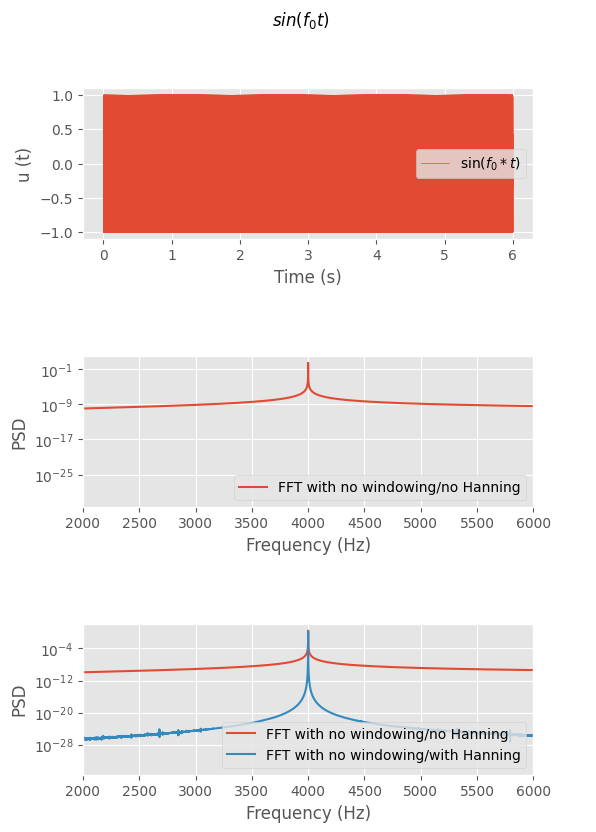

In [215]:
# Plot FFT results
title = r'$sin(f_0 t)$'
plot_ffts = plot_full_fft(t = waveform_parameters["Time array"], waveform = waveform_parameters["Constant signal"], 
                        freq_nh = FFT_results["FFT frequencies (no Hanning)"], mag_nh = FFT_results["FFT (no Hanning)"],
                        freq_h = FFT_results["FFT frequencies (Hanning)"],mag_h = FFT_results["FFT (Hanning)"],title = title)

# 2. Rising tone (same temporal sampling/duration as previous example)

In [216]:
# Get frequency function wrt time
f_t = frequency_t(frequency_lower=2500, frequency_upper=3000,time_array= waveform_parameters["Time array"],duration = waveform_parameters["Waveform duration"], style = "Quadratic")

# Get waveform for time varying part
waveform_t = rising_tones(f_t,time_array)

waveform_parameters["Time-varying signal"] = waveform_t
# Do FFT over entire duration - with and without hanning windowing turned on

mag_nh,freq_nh, bu_fft_nh = fft_full(waveform_parameters["Constant signal"]+ waveform_parameters["Time-varying signal"],waveform_parameters["Sampling timestep"],hanning=False)
mag_h,freq_h, bu_fft_h = fft_full(waveform_parameters["Constant signal"]+ waveform_parameters["Time-varying signal"],waveform_parameters["Sampling timestep"],hanning=True)


# save to FFT results dictionary

FFT_results = {"FFT (no Hanning)": mag_nh,                                        # save parameters to dictionary
            "FFT frequencies (no Hanning)": freq_nh,
            "FFT (Hanning)": mag_h,
            "FFT frequencies (Hanning)": freq_h}



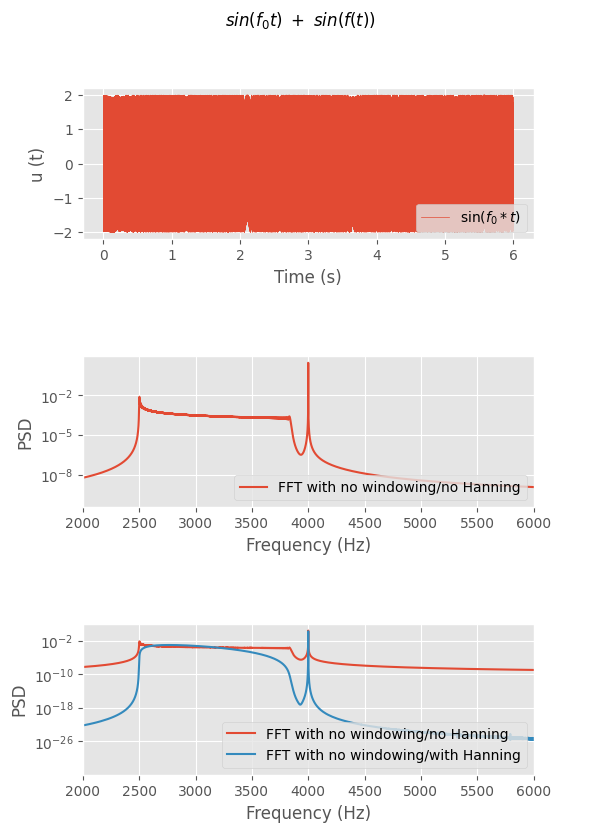

In [217]:
# Plot FFT results
title = r'$sin(f_0 t)\ +\ sin(f(t))$'
plot_ffts = plot_full_fft(t = waveform_parameters["Time array"], waveform = waveform_parameters["Constant signal"]+waveform_parameters["Time-varying signal"], 
                        freq_nh = FFT_results["FFT frequencies (no Hanning)"], mag_nh = FFT_results["FFT (no Hanning)"],
                        freq_h = FFT_results["FFT frequencies (Hanning)"],mag_h = FFT_results["FFT (Hanning)"],title = title)

# 2.b) Now doing the above waveform again but using windows

In [218]:
import pandas as pd

In [219]:
list_results =[]
for i in range(1,6):

    mag_windows,freq_windows,fft_av_windows,t_array_windows,df = fft_sliding(waveform_parameters["Constant signal"]+waveform_parameters["Time-varying signal"],
                                                                                waveform_parameters["Sampling timestep"],5*i,100) #fft_windows(u_burst,f_s,5*i)

    FFT_results_windows= {"FFT spectra": mag_windows,                                        # save parameters to dictionary
                "FFT frequencies": freq_windows,
                "FFT spectra average": fft_av_windows,
                "FFT time array":t_array_windows,
                "Frequency bandwidth":df}

    window_results= FFTMagnitude(FFT_results_windows["FFT spectra"], FFT_results_windows["FFT frequencies"],5*i,100)
    test.show_frequency()
    test.show_magnitude()
    list_results.append(window_results)


the frequency bands for little bins are 0.8333333333333334
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)
the frequency bands for little bins are 1.6666666666666667
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)
the frequency bands for little bins are 2.5
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)
the frequency bands for little bins are 3.3333333333333335
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)
the frequency bands for little bins are 4.166666666666667
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)


1680
1890
1960
1995
2016


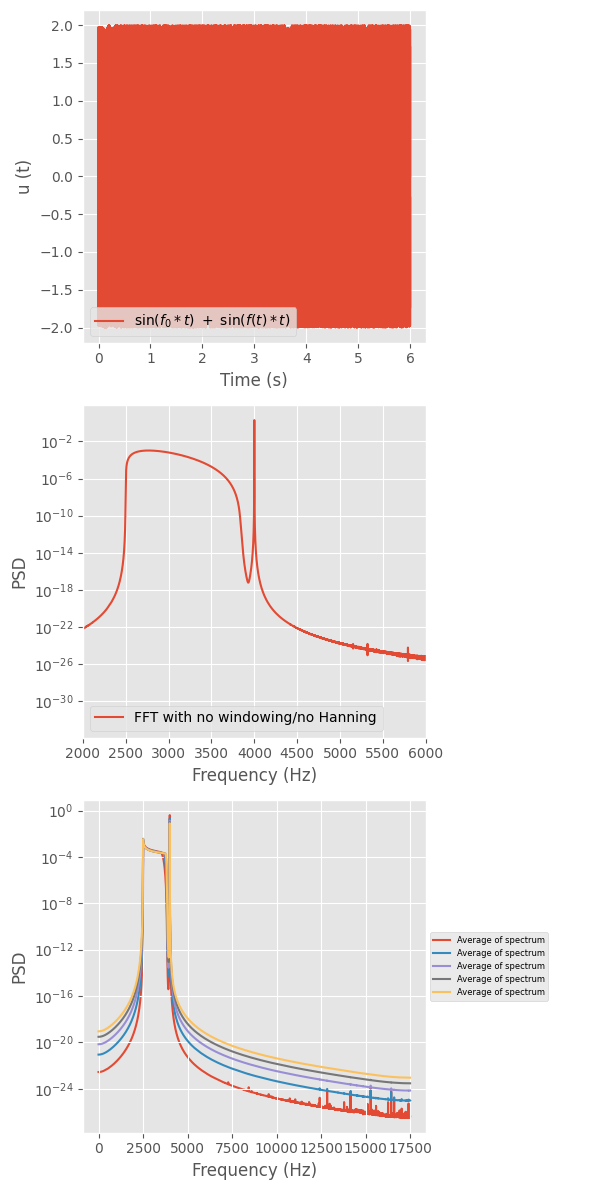

In [220]:

""" Creating the plots for the FFT over the full interval """

# create figure
fig, axs = plt.subplots(3,2,gridspec_kw={"width_ratios":(1,0.05)})

# Name plot axis
ax1,ax2,ax3= axs[:, 0]

# Name colourbar axis (the third/fourth one will be made invisible)
cax1,cax2,cax3 = axs[:,1]


ax1.plot(waveform_parameters["Time array"], waveform_parameters["Constant signal"]+waveform_parameters["Time-varying signal"], label=r'$\sin(f_0*t)\ +\ \sin(f(t)*t)$')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("u (t)")
ax1.legend()
cax1.axis('off')

ax2.plot(FFT_results["FFT frequencies (Hanning)"],FFT_results["FFT (Hanning)"],label="FFT with no windowing/no Hanning")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("PSD")
ax2.set_yscale('log')
# set limits aroud peak in frequency
peak_freq = FFT_results["FFT frequencies (Hanning)"][np.argmax(FFT_results["FFT (Hanning)"])]
ax2.set_xlim(peak_freq-peak_freq/2,peak_freq+peak_freq/2) 
ax2.legend()
cax2.axis('off')

for i in range(0,5):


    

    average = average_windows(list_results[i].magnitude,list_results[i].frequency)
    ax3.plot(list_results[i].frequency,average,label="Average of spectrum",zorder = (i))
       
    #ax4.plot(list_results[i].frequency,list_results[i].magnitude[j,:],label="Window number: "+ str(j+1))
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("PSD")
    ax3.set_yscale('log')

    cax3.axis('off')
       


ax3.legend()
ax3.legend(loc='center left',bbox_to_anchor=(1., 0.5),fontsize = 6)

plt.gcf().set_size_inches((6, 12))
plt.tight_layout()
plt.show()

the frequency bands for little bins are 1.6666666666666667


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


the frequency bands for little bins are 3.3333333333333335


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


the frequency bands for little bins are 5.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


the frequency bands for little bins are 6.666666666666667


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


the frequency bands for little bins are 8.333333333333334


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


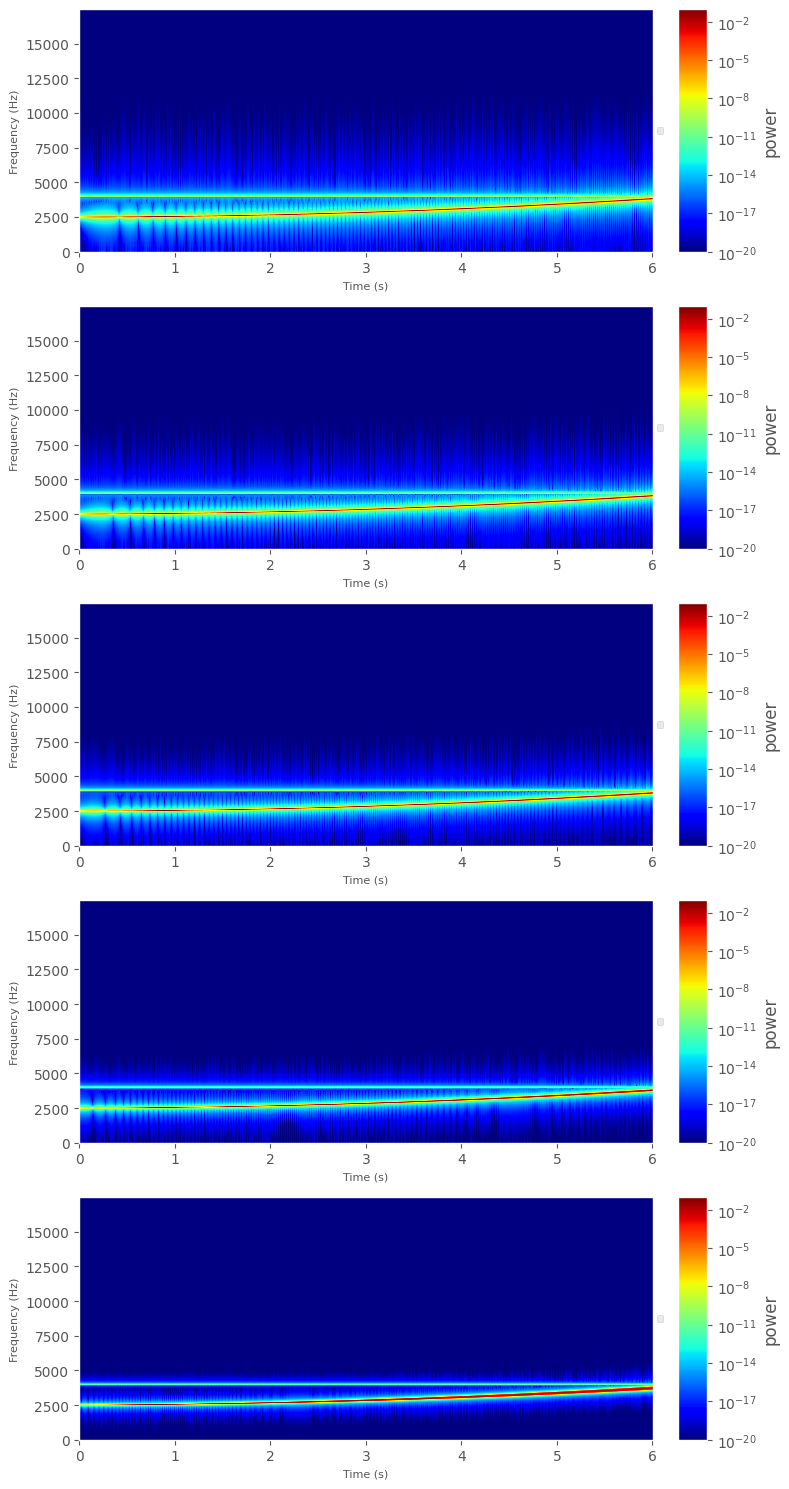

In [221]:
# for plotting
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

fig, axs = plt.subplots(5,2,gridspec_kw={"width_ratios":(1,0.05)})

# Name plot axis
ax1,ax2,ax3,ax4,ax5= axs[:, 0]

# Name colourbar axis (the third/fourth one will be made invisible)
cax1,cax2,cax3,cax4,cax5 = axs[:,1]


for i in range(1,6):

    mag_windows,freq_windows,fft_av_windows,t_array_windows,df = fft_sliding(waveform_parameters["Constant signal"]+waveform_parameters["Time-varying signal"],
                                                                                waveform_parameters["Sampling timestep"],10*i,100)#fft_windows(u_burst,f_s,5*i)
    
   
    colorbar_norm = mcolors.LogNorm(vmin=10**(-20), vmax=10**(-1))

    window_plot = axs[5-i,0].pcolormesh(t_array_windows, freq_windows, np.transpose(mag_windows), norm=colorbar_norm, cmap="jet",label = "FFT spectrum "+str(20*i-1)+" windows")
    axs[i-1,0].set_ylabel('Frequency (Hz)',fontsize=8)
    axs[i-1,0].set_xlabel('Time (s)',fontsize=8)
    plt.colorbar(window_plot,label='power',cax=axs[i-1,1])
    axs[i-1,0].legend()
    axs[i-1,0].legend(loc='center left',bbox_to_anchor=(1., 0.5),fontsize = 6)

plt.gcf().set_size_inches((8, 15))
plt.tight_layout()
plt.show()

# Waveform 3

constant signal + constant signal that is switched on/off in time

In [222]:
# Get waveform for time varying part
waveform_t = on_off_constant_signal(5000,time_array)

waveform_parameters["Time-varying signal"] = waveform_t
# Do FFT over entire duration - with and without hanning windowing turned on

mag_nh,freq_nh, bu_fft_nh = fft_full(waveform_parameters["Constant signal"]+ waveform_parameters["Time-varying signal"],waveform_parameters["Sampling timestep"],hanning=False)
mag_h,freq_h, bu_fft_h = fft_full(waveform_parameters["Constant signal"]+ waveform_parameters["Time-varying signal"],waveform_parameters["Sampling timestep"],hanning=True)


# save to FFT results dictionary

FFT_results = {"FFT (no Hanning)": mag_nh,                                        # save parameters to dictionary
            "FFT frequencies (no Hanning)": freq_nh,
            "FFT (Hanning)": mag_h,
            "FFT frequencies (Hanning)": freq_h}

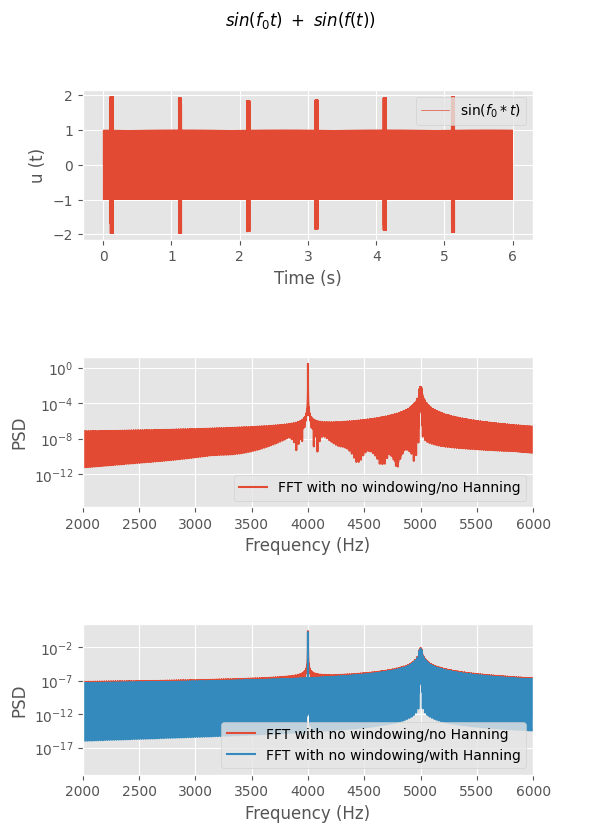

In [223]:
# Plot FFT results
title = r'$sin(f_0 t)\ +\ sin(f(t))$'
plot_ffts = plot_full_fft(t = waveform_parameters["Time array"], waveform = waveform_parameters["Constant signal"]+waveform_parameters["Time-varying signal"], 
                        freq_nh = FFT_results["FFT frequencies (no Hanning)"], mag_nh = FFT_results["FFT (no Hanning)"],
                        freq_h = FFT_results["FFT frequencies (Hanning)"],mag_h = FFT_results["FFT (Hanning)"],title = title)

In [224]:
list_results =[]
for i in range(1,6):

    mag_windows,freq_windows,fft_av_windows,t_array_windows,df = fft_sliding(waveform_parameters["Constant signal"]+waveform_parameters["Time-varying signal"],
                                                                                waveform_parameters["Sampling timestep"],5*i,100) #fft_windows(u_burst,f_s,5*i)

    FFT_results_windows= {"FFT spectra": mag_windows,                                        # save parameters to dictionary
                "FFT frequencies": freq_windows,
                "FFT spectra average": fft_av_windows,
                "FFT time array":t_array_windows,
                "Frequency bandwidth":df}

    window_results= FFTMagnitude(FFT_results_windows["FFT spectra"], FFT_results_windows["FFT frequencies"],5*i,100)
    test.show_frequency()
    test.show_magnitude()
    list_results.append(window_results)

the frequency bands for little bins are 0.8333333333333334
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)
the frequency bands for little bins are 1.6666666666666667
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)
the frequency bands for little bins are 2.5
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)
the frequency bands for little bins are 3.3333333333333335
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)
the frequency bands for little bins are 4.166666666666667
The number of frequencies is: 1
The dimensions (time bins, frequency bins) of this FFT spectra is: (2,)


1680
1890
1960
1995
2016


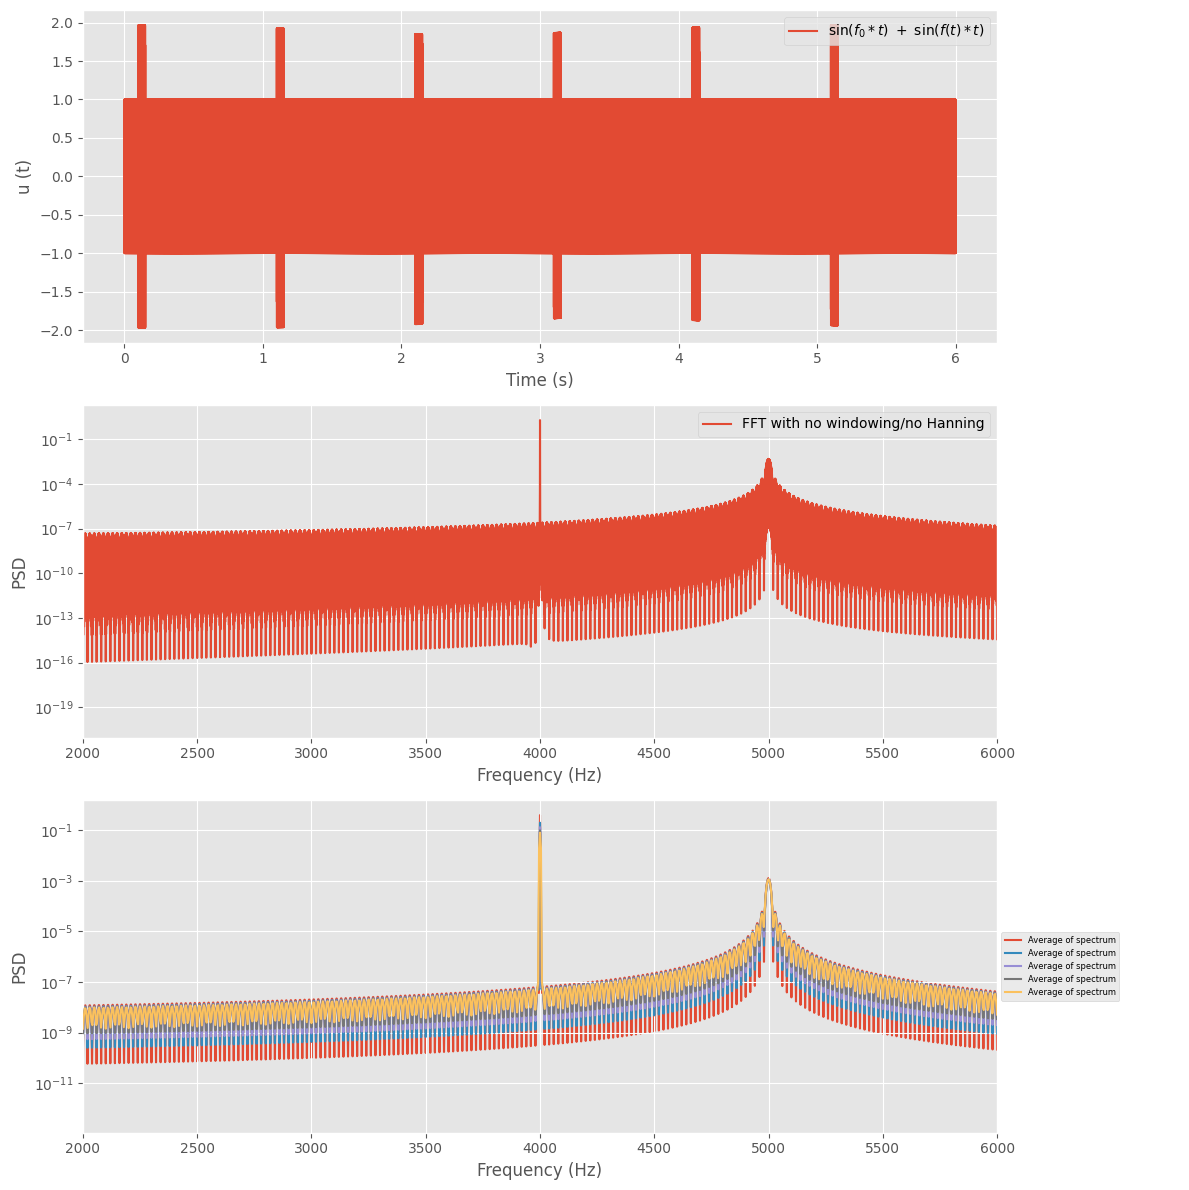

In [225]:

""" Creating the plots for the FFT over the full interval """

# create figure
fig, axs = plt.subplots(3,2,gridspec_kw={"width_ratios":(1,0.05)})

# Name plot axis
ax1,ax2,ax3= axs[:, 0]

# Name colourbar axis (the third/fourth one will be made invisible)
cax1,cax2,cax3 = axs[:,1]


ax1.plot(waveform_parameters["Time array"], waveform_parameters["Constant signal"]+waveform_parameters["Time-varying signal"], label=r'$\sin(f_0*t)\ +\ \sin(f(t)*t)$')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("u (t)")
ax1.legend()
cax1.axis('off')

ax2.plot(FFT_results["FFT frequencies (Hanning)"],FFT_results["FFT (Hanning)"],label="FFT with no windowing/no Hanning")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("PSD")
ax2.set_yscale('log')
# set limits aroud peak in frequency
peak_freq = FFT_results["FFT frequencies (Hanning)"][np.argmax(FFT_results["FFT (Hanning)"])]
ax2.set_xlim(peak_freq-peak_freq/2,peak_freq+peak_freq/2) 
ax2.legend()
cax2.axis('off')

for i in range(0,5):


    

    average = average_windows(list_results[i].magnitude,list_results[i].frequency)
    ax3.plot(list_results[i].frequency,average,label="Average of spectrum",zorder = (i))
       
    #ax4.plot(list_results[i].frequency,list_results[i].magnitude[j,:],label="Window number: "+ str(j+1))
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("PSD")
    ax3.set_yscale('log')
    ax3.set_xlim(peak_freq-peak_freq/2,peak_freq+peak_freq/2) 

    cax3.axis('off')
       


ax3.legend()
ax3.legend(loc='center left',bbox_to_anchor=(1., 0.5),fontsize = 6)



plt.gcf().set_size_inches((12, 12))
plt.tight_layout()
plt.show()

the frequency bands for little bins are 2.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


the frequency bands for little bins are 4.166666666666667


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


the frequency bands for little bins are 5.833333333333333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


the frequency bands for little bins are 7.5010715816545215


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


the frequency bands for little bins are 9.167103195390256


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


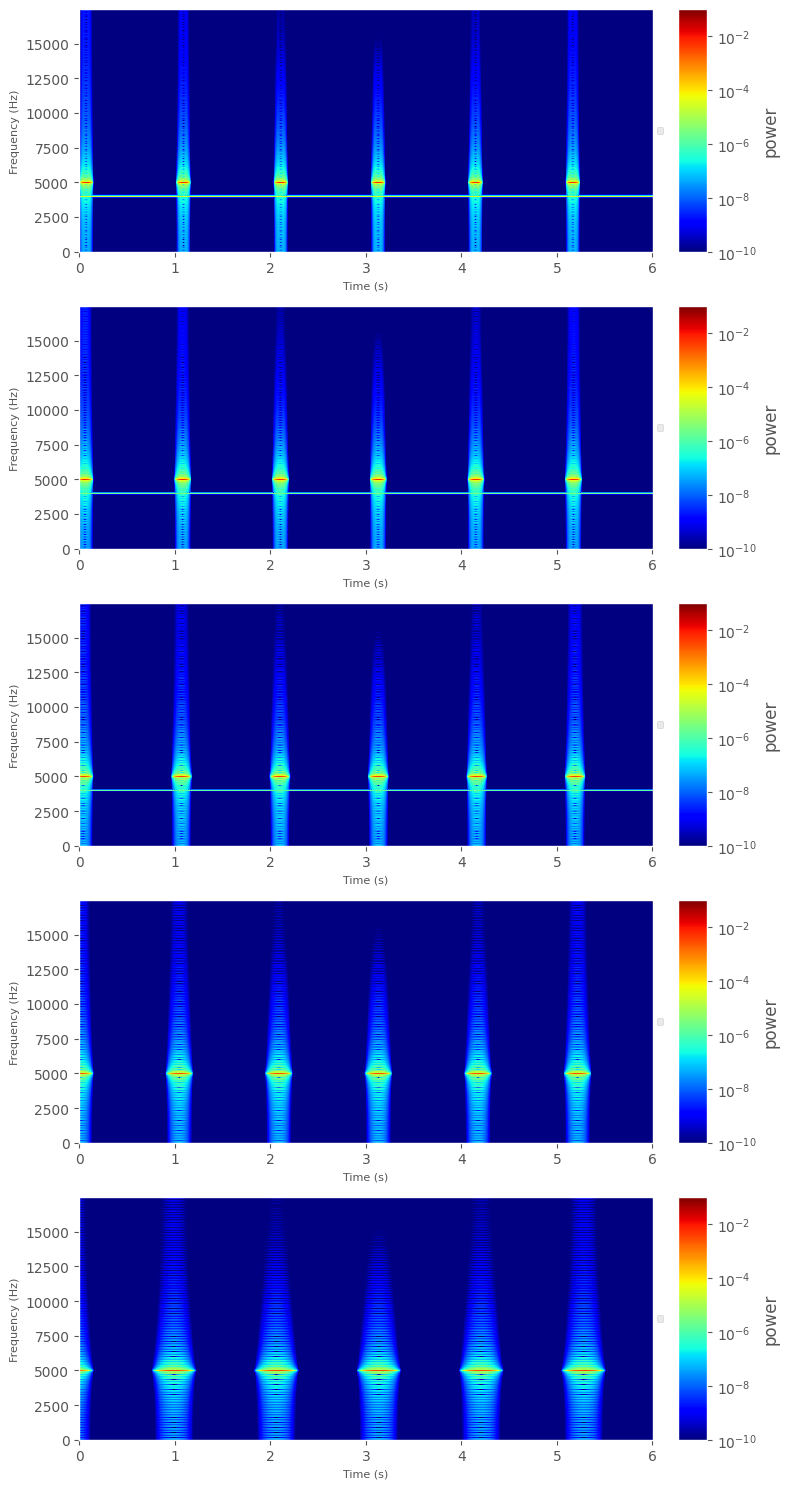

In [226]:
# for plotting
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

fig, axs = plt.subplots(5,2,gridspec_kw={"width_ratios":(1,0.05)})

# Name plot axis
ax1,ax2,ax3,ax4,ax5= axs[:, 0]

# Name colourbar axis (the third/fourth one will be made invisible)
cax1,cax2,cax3,cax4,cax5 = axs[:,1]


for i in range(1,6):

    mag_windows,freq_windows,fft_av_windows,t_array_windows,df = fft_sliding(waveform_parameters["Constant signal"]+waveform_parameters["Time-varying signal"],
                                                                                waveform_parameters["Sampling timestep"],5+10*i,100)#fft_windows(u_burst,f_s,5*i)
    
   
    colorbar_norm = mcolors.LogNorm(vmin=10**(-10), vmax=10**(-1))

    window_plot = axs[5-i,0].pcolormesh(t_array_windows, freq_windows, np.transpose(mag_windows), norm=colorbar_norm, cmap="jet",label = "FFT spectrum "+str(20*i-1)+" windows")
    axs[i-1,0].set_ylabel('Frequency (Hz)',fontsize=8)
    axs[i-1,0].set_xlabel('Time (s)',fontsize=8)
    plt.colorbar(window_plot,label='power',cax=axs[i-1,1])
    axs[i-1,0].legend()
    axs[i-1,0].legend(loc='center left',bbox_to_anchor=(1., 0.5),fontsize = 6)

plt.gcf().set_size_inches((8, 15))
plt.tight_layout()
plt.show()

In [227]:
def integrate_in_small_windows(B,freq,time_array):

    n_f = len(freq)
    n_bins = len(time_array)

    frequency_integral = np.zeros(n_bins)
    
    for n in range(n_bins):
        high_res_bint=0 
        # Integrate in frequency 
        for m in range(1,n_f-1):
                
            high_res_bint = high_res_bint + 0.5*(B[n,m]+B[n,m+1])*(freq[m+1]-freq[m])
                    
        frequency_integral[n] = high_res_bint

    max_amplitude = np.max(frequency_integral)

    total_integral = 0.
    for n in range(n_bins-1):
        
        total_integral = total_integral + 0.5*(frequency_integral[n]+frequency_integral[n+1])*(time_array[n+1]-time_array[n])
    
    print("the full integral is", total_integral)

    return frequency_integral, total_integral,max_amplitude

In [228]:
def rebin(bin_edges,mag,frequency_original):
    """ 
    Doing the rebinning
    """
    import pandas as pd

    # Create dataframe
    rebin_dat=pd.DataFrame()

    rebin_dat['Data'] = mag
    
    # Create and save frequencies to one column
    rebin_dat['Frequency']= frequency_original
    
    """
    pd.cut() bins all frequencies according to defined semi_log bins
    groupby() groups all data in frame by these bines
    then select the DATA and take the MEAN in each bin
    to_numpy saves this to an array
    """
    
    rebinned=rebin_dat.groupby(pd.cut(rebin_dat.Frequency,bins=bin_edges)).Data.mean().to_numpy()
    
    return rebinned

In [229]:
def integrate_in_rebin(B,survey_freq):

    integral=0 
    for m in range(0,len(survey_freq)-1):
                        
        integral = integral + 0.5*(B[m]+B[m+1])*(survey_freq[m+1]-survey_freq[m])

    return integral

In [230]:
# Attempting the total integral
total_integral_list = []
max_amplitude_list = []
n = []
for j in range(1,7):

    n_windows = 5+10*j
    n.append(n_windows)

    mag_windows,freq_windows,fft_av_windows,t_array_windows,df= fft_sliding(waveform_parameters["Constant signal"]+ waveform_parameters["Time-varying signal"],
                                                                                    waveform_parameters["Sampling timestep"],n_windows,10)

    frequency_integral, total_integral,max_amplitude = integrate_in_small_windows(mag_windows,freq_windows,t_array_windows)
    total_integral_list.append(total_integral)
    max_amplitude_list.append(max_amplitude)


the frequency bands for little bins are 2.5
the full integral is 3.136721468474558
the frequency bands for little bins are 4.166666666666667
the full integral is 3.1445698310602723
the frequency bands for little bins are 5.833333333333333
the full integral is 3.152216917749255
the frequency bands for little bins are 7.5010715816545215
the full integral is 3.153280470865299
the frequency bands for little bins are 9.167103195390256
the full integral is 3.152763002260821
the frequency bands for little bins are 10.835913312693497
the full integral is 3.1523345481953813


3.726574283890994e-05


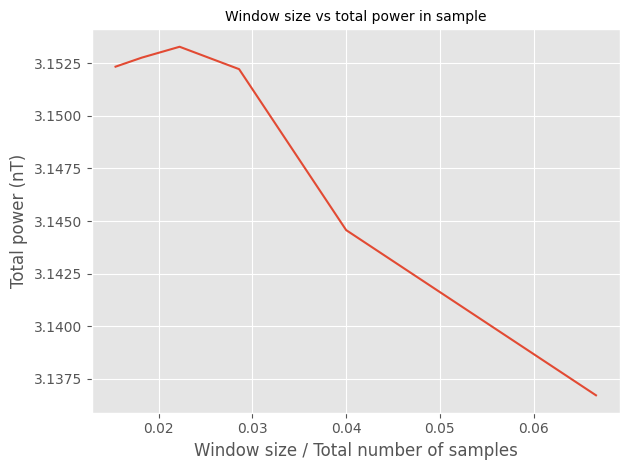

In [231]:
plt.style.use('ggplot')
plt.title(f'Window size vs total power in sample',fontsize=10)
plt.plot(1/np.asarray(n),total_integral_list)
plt.xlabel(f'Window size / Total number of samples')
plt.ylabel(f'Total power (nT)')
plt.tight_layout()
print(np.std(total_integral_list)**2)


3.726574283890994e-05


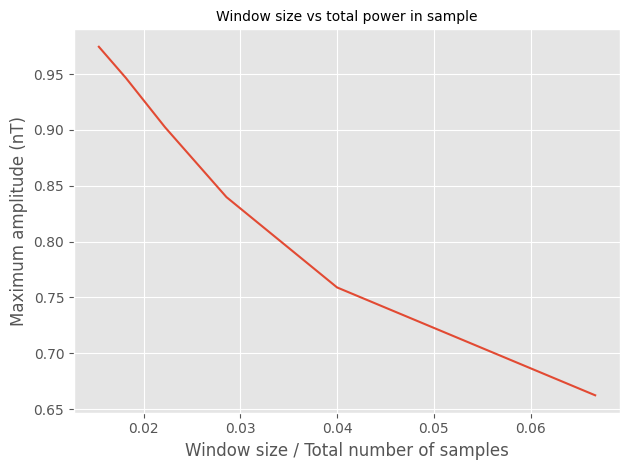

In [232]:
plt.style.use('ggplot')
plt.title(f'Window size vs total power in sample',fontsize=10)
plt.plot(1/np.asarray(n),max_amplitude_list)
plt.xlabel(f'Window size / Total number of samples')
plt.ylabel(f'Maximum amplitude (nT)')
plt.tight_layout()
print(np.std(total_integral_list)**2)

NameError: name 'u0' is not defined

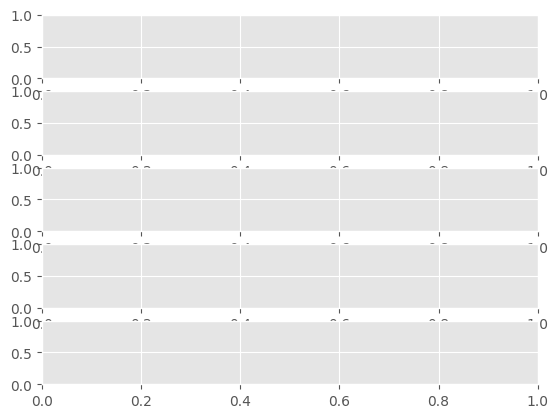

In [233]:
fig, axs = plt.subplots(5,1)


for i in range(1,6):

    mag_windows,freq_windows,fft_av_windows,t_array_windows,df= fft_windows(u0+u_t,f_s,5*i)

    bin_edges = list(freq_windows)
    bin_edges.append(bin_edges[-1]+df)

    rebinned_fullFFT = rebin(bin_edges,mag_h,freq_h)

    #dist_original = integrate_in_rebin(rebinned_fullFFT,freq_windows)
    dist_original = integrate_in_rebin(mag_h,freq_h)
    av_windows = average_windows(mag_windows,freq_windows)

    # integrate dist windows in frequency

    dist_windows = integrate_in_rebin(av_windows,freq_windows)



    axs[5-i].plot(freq_windows,rebinned_fullFFT,label = "Full interval FFT")
    axs[5-i].plot(freq_windows,av_windows,label = "FFT with overlapping windows")
    axs[5-i].set_xlim(0,f0+f0/2)

    axs[5-i].set_yscale('log')
    axs[5-i].set_xlabel("Frequency")
    axs[5-i].set_ylabel("Power spectral density")
    axs[5-i].legend(loc='lower left')
    print(5-i,'done')
    print(dist_original,dist_windows)
    
#plt.tight_layout()
plt.gcf().set_size_inches((6, 15))
plt.tight_layout()
plt.show()

    